# Time Series - Lecture 3: ARIMA

The goal of time series is similar to regressions in that we are trying to separate **trends/patterns/model** from **resisduals/noise**. The difference is that time is a useful component in finding trends/patterns.

Today, we will focus on **the art of separating** trends/patterns/model from resisduals/noise. In other words:
1. Building ARIMA(p,d,q) model
2. How to decide on the model? 
    - Autocorrelations (e.g., ACF and PACF)
    - Information Criteria (e.g., AIC and BIC)

## Review of AR(p) and MA(q)

Let's review from last lecture on AR(p) and MA(q) models.
- An **AR(p) model** is written as:
$$y_t = \beta_0 + \beta_1y_{t-1} + \beta_2y_{t-2} + \cdots + \beta_py_{t-p}+\epsilon_t$$
- An **MA(q) model** is written as: $$y_t=\beta_0+\epsilon_t+\beta_1\epsilon_{t-1}+\cdots+\beta_q\epsilon_{t-q}$$



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

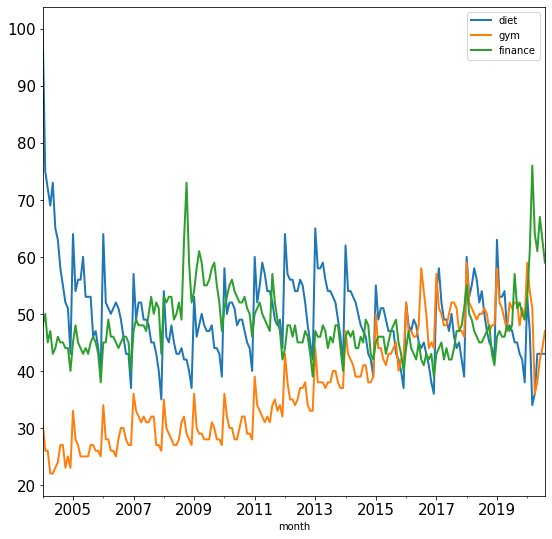

In [5]:
df = pd.read_csv('data/multiTimeline.csv', skiprows=1)
df.columns = ['month', 'diet', 'gym', 'finance']
df.month = pd.to_datetime(df.month)
df.set_index('month', inplace=True)
df.index = pd.DatetimeIndex(df.index).to_period('M')
df.plot(figsize=(9,9), linewidth=2, fontsize=15)

## ARMA(p,q)

- **ARMA(p,q)** models are combination of the AR(p) and the MA(q) moodels.
- An **ARMA(p,q) model** is written as:
$$y_t = \beta_0 + \epsilon_t + \sum_{i=1}^p\phi_iy_{t-i} + \sum_{j=1}^q\varphi_j\epsilon_{t-j}$$
- Just as AR(p) and MA(q) models
    - p = order of the autoregressive part
    - q = order of the moving average part

## ARIMA(p,d,q)
- **ARIMA(p,d,q)** models are combination of differencing, the **AR(p)** and the **MA(q)** models.
- An **ARIMA(p,d,q) model** is written as:
$$y'_t = \beta_0 + \epsilon_t + \sum_{i=1}^p\phi_iy'_{t-i} + \sum_{j=1}^q\varphi_j\epsilon_{t-j}$$
where $y'_t=y_t-y_{t-1}$. 
- ARIMA(p,d,q) has three parameters:
    - p = order of the autoregressive part
    - d = degree of first differencing involved
    - q = order of the moving average part

Notice that ARIMA model emcompassess all the previous models that we have discussed. AR(p), MA(q), and ARMA(p,q) are all special cases of ARIMA models. To sumarize the special cases of ARIMA models:

- ARIMA(0,0,0): White noise
- ARIMA(0,1,0) with $\beta_0=0$: Random walk
- ARIMA(0,1,0) with $\beta_0\neq0$: Random walk with draft
- ARIMA(p,0,0): AR(p)
- ARIMA(0,0,q): MA(q)
- ARIMA(0,1,1): a basic exponential smoothing model
- ARIMA(0,2,2): a double exponential smoothing model

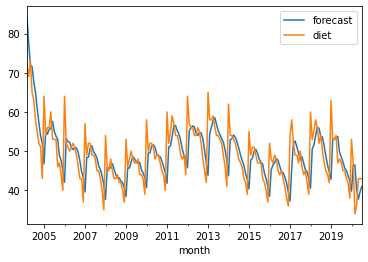

                             ARIMA Model Results                              
Dep. Variable:                 D.diet   No. Observations:                  199
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -643.426
Method:                       css-mle   S.D. of innovations              6.133
Date:                Mon, 21 Sep 2020   AIC                           1296.852
Time:                        22:42:06   BIC                           1313.319
Sample:                    02-29-2004   HQIC                          1303.517
                         - 08-31-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.2316      0.251     -0.924      0.356      -0.723       0.260
ar.L1.D.diet    -0.4721      0.074     -6.360      0.000      -0.618      -0.327
ar.L2.D.diet    -0.2121      0.081     -2.62

In [6]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df.diet, order=(3,1,0))
result=model.fit(disp=0)
result.plot_predict(start='2004-03-01',end='2020-07-01')
plt.show()
print(result.summary())

## How to Choose Model/Parameter?

Deciding on appropriate parameters such as $p$, $d$ and $q$ in these models are the **ART** of data science/modeling.

### Stationarity (Augmented Dickey-Fuller Test) for selecting $d$
- Recall from the previous lecture that differencing can be helpful in turning your time series into a stationary time series. 
- [Augmented Dickey-Fuller Test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) or [KPSS test
](https://en.wikipedia.org/wiki/KPSS_test) can check whether the data is stationary
- If not stationary, then take first differences of the data until the data are stationary

Let's focus for now on Augmented Dickey-Fuller test. (Further reading [here](https://machinelearningmastery.com/time-series-data-stationary-python/))
- Null hypothesis of the test is that the data is non-stationary.
- If the null is rejected, then the data is stationary.

Rule of thumb for rejecting the null, p-value$\leq$0.05

In [110]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.diet)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.648544
p-value: 0.457800
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


In [111]:
result = adfuller(df.diet.diff()[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.665529
p-value: 0.004625
Critical Values:
	1%: -3.467
	5%: -2.877
	10%: -2.575


We use can use first difference, or $d=1$.

### Autocorrelations (ACF and PACF) for selecting $p$ and $q$

- When there exist correlation between lagged values of a time series data set, we cann it **autocorrelation**, and is written as: $$ r_k=\frac{\sum_{t=k+1}^T(y_t-\bar{y})(y_{t-k}-\bar{y})}{\sum_{t=1}^T(y_t-\bar{y})^2}$$ where $r_1$ measures the relationship between $y_t$ and $y_{t-1}$; $r_2$ measures the relationship between $y_t$ and $y_{t-2}$ and so on.
- **ACF** (**A**uto**C**orrelation **F**unction) measures the relationship/autocorrelation between $y_t$ and $y_{t-k}$.
- **PACF** (**P**artial **A**uto**C**orrelation **F**unction) measures the relationship/autocorrelation between $y_t$ and $y_{t-k}$ after removing the effects of lags $1,2,\dots,k-1$.
- Python has built in function with confidence interval calculated

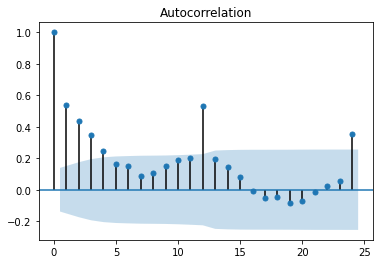

In [112]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.diet)
plt.show()

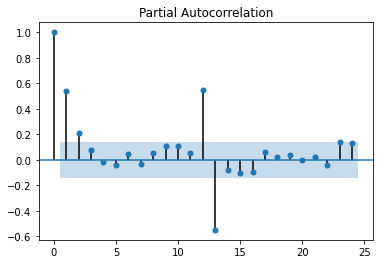

In [113]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df.diet)
plt.show()

ACF and PACF can help determining values for $p$ and $q$. 
- ARIMA(p,d,0) models follow the following patters:
    - ACF is exponeneitally decaying or sinusoidal;
    - there is a significant spike at lag $p$ in the PACF, but none beyond lag $p$
- ARIMA(0,d,q) models follow the following patters:
    - the PACF is exponentially decaying or sinusoidal;
    - there is a significant spike at lag $q$ in the ACF, but none beyond lag $q$
    
Which values of $p$ and $q$ would you select?
 

In [114]:
model=ARIMA(df['diet'], order=(2,1,0))
result = model.fit()
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.diet   No. Observations:                  199
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -643.709
Method:                       css-mle   S.D. of innovations              6.142
Date:                Sun, 20 Sep 2020   AIC                           1295.418
Time:                        21:16:57   BIC                           1308.591
Sample:                    02-29-2004   HQIC                          1300.750
                         - 08-31-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.2366      0.265     -0.892      0.372      -0.757       0.283
ar.L1.D.diet    -0.4607      0.073     -6.330      0.000      -0.603      -0.318
ar.L2.D.diet    -0.1853      0.073     -2.55

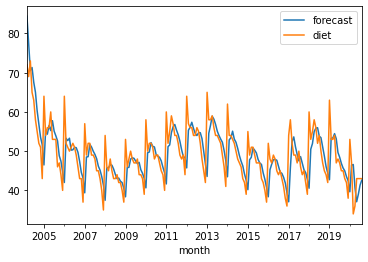

In [115]:
result.plot_predict(start='2004-03-01',end='2020-08-01')
plt.show()

There are some freedom to choose the parameter values, but how to decide the optimal model?

### Information Criteria

Information criteria, or probabilitic model selection, provides a metric to choose an optimal model/parameters based on 
1. Model performance: goodness of fit
2. Model complexity: all else being equal, penalize the complex model (idea of [Occam's razor](https://simple.wikipedia.org/wiki/Occam%27s_razor))

Two of the most popular criteria are:
1. **AIC**, or Akaike Information Criterion
    - The model with the lowest AIC is selected
    - Compared to the BIC method (below), penalizes complex models less; more emphasis on model performance
2. **BIC**, or Bayesian Information Criterion
    - The model with the lowest BIC  is selected
    - Compared to the AIC method (above), penalizes complex models more

### Automated  Hyndman & Khandakar Algorithm 
In 2008, [Hyndman & Khandakar algorithm](https://www.jstatsoft.org/article/view/v027i03) was punlished to automatically select the parameter values. In Python, the "pmdarima" package is analogous. Here is the algorithm:
1. The number of differences, or $d$, is determined
2. The values of $p$ and $q$ are chosen by minimizing intformation criteria.

In [116]:
from pmdarima.arima import auto_arima
model = auto_arima(df.diet, trace=True, error_action='ignore', suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1292.086, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1327.894, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1299.824, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1290.617, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1326.253, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1290.149, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1290.129, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1295.416, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1292.015, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1290.464, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1296.850, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1293.832, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1289.864, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1289.849, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]          

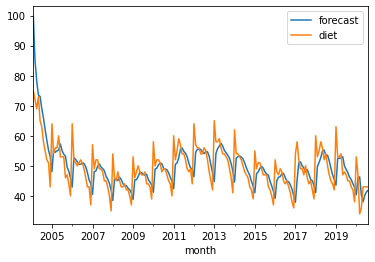

In [117]:
model = ARIMA(df.diet, order=(0,1,1))
result=model.fit(disp=0)
result.plot_predict(start=1,end=199)
plt.show()

## Recap:
- You've had deep dive into ARIMA model.
- You've automated ARIMA model to choose the "optimal" parameters/model.
- Now, you can a logical argument/reason for choosing a specific model for time seies data!

## Up next:
Review and some other machine learning models in time series.

# Activities

All of the activities below should be done with your chosen data set. 

1. Check stationarity by performing a test such as Augmented Dickey-Fuller Test, and select $d$ that is appropriate for your data.
2. Plot ACF and PACF. Based on the result, pick $p$ and $q$.
3. Use auto_arima function to get the result of best model.
4. Plot the result from auto_arima.
5. Compare the plots, AIC, and BIC from all the models that you have estimated.

## References

The materials presented here are inspired and modified from the following sources:
- https://otexts.com/fpp2/
- https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
- https://en.wikipedia.org/wiki/KPSS_test
- https://machinelearningmastery.com/time-series-data-stationary-python/
- https://machinelearningmastery.com/probabilistic-model-selection-measures/
- https://www.jstatsoft.org/article/view/v027i03
- https://alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html
- https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd
